In [46]:
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import math
from functools import reduce
import random
%matplotlib inline
np.random.seed(42)

In [47]:
def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

In [48]:
X_train, Y_train, X_test, Y_test = load()

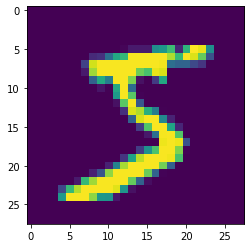

In [49]:
plt.imshow(X_train[0].reshape(28,28))

In [50]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    N, C, H, W = img.shape
    NN, CC, HH, WW = img.strides
    out_h = (H - filter_h)//stride + 1
    out_w = (W - filter_w)//stride + 1
    col = np.lib.stride_tricks.as_strided(img, (N, out_h, out_w, C, filter_h, filter_w), (NN, stride * HH, stride * WW, CC, HH, WW)).astype(float)
    return col.reshape(np.multiply.reduceat(col.shape, (0, 3)))

In [51]:
a = np.random.random((3,2,3,3))
print(a)
print(im2col(a, 2, 2).shape)

[[[[0.37454012 0.95071431 0.73199394]
   [0.59865848 0.15601864 0.15599452]
   [0.05808361 0.86617615 0.60111501]]

  [[0.70807258 0.02058449 0.96990985]
   [0.83244264 0.21233911 0.18182497]
   [0.18340451 0.30424224 0.52475643]]]


 [[[0.43194502 0.29122914 0.61185289]
   [0.13949386 0.29214465 0.36636184]
   [0.45606998 0.78517596 0.19967378]]

  [[0.51423444 0.59241457 0.04645041]
   [0.60754485 0.17052412 0.06505159]
   [0.94888554 0.96563203 0.80839735]]]


 [[[0.30461377 0.09767211 0.68423303]
   [0.44015249 0.12203823 0.49517691]
   [0.03438852 0.9093204  0.25877998]]

  [[0.66252228 0.31171108 0.52006802]
   [0.54671028 0.18485446 0.96958463]
   [0.77513282 0.93949894 0.89482735]]]]
(12, 8)


In [52]:
class FC:
    def __init__(self, in_channel, out_channel):
        self.W = {'val': np.random.standard_normal((in_channel,out_channel)), 'grad': 0}
        self.b = {'val': np.random.randn(out_channel), 'grad': 0}
        self.cache = None
    
    def forward(self, X):
        out = np.dot(X, self.W['val']) + self.b['val']
        self.cache = X
        return out
    
    def backward(self, dout):
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        return dX

In [53]:
class Conv2d():
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, init_params=False):
        """
        :param in_channels: (int) the input channel
        :param out_channels: (int) the output channel
        :param kernel_size: (int) the kernel size
        :param stride: (int) the stirde
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.input_h = None
        self.input_w = None
        self.out_h = None
        self.out_w = None

        self.init_params = init_params

        self.W = {'val': np.random.randn(self.in_channels, self.out_channels, self.kernel_size, self.kernel_size), 'grad': 0}
        self.b = {'val': np.random.randn(self.out_channels, 1), 'grad': 0}


        # 输入图像的batch_size=N，默认为1
        self.batch_size = 1



    def forward(self, x):
        """
        :param x: (N, C_in, H_in, W_in) 通道*高度*宽度
        :return: 
        """
        self.input_map = x

        if not self.init_params:
            self.init_params = True
            weights_scale = math.sqrt(reduce(lambda x, y: x * y, self.input_map.shape) / self.out_channels)

            self.W['val'] = np.random.standard_normal(
                size=(self.in_channels, self.out_channels, self.kernel_size, self.kernel_size)) / weights_scale
            self.b['val'] = np.random.standard_normal(size=(self.out_channels, 1)) / weights_scale

        self.batch_size, _, self.input_h, self.input_w = x.shape

        self.out_h = (self.input_h-self.kernel_size)//self.stride + 1
        self.out_w = (self.input_w-self.kernel_size)//self.stride + 1
        self.col_images = []

        weight_col = self.W['val'].reshape(self.out_channels, -1)
        conv_out = np.zeros((self.batch_size, self.out_channels, self.out_h, self.out_w))
        for batch_i in range(self.batch_size):
            # 输入的第i个图像C_in*H_in*W_in
            image_batch_i = x[batch_i, :]
            image_batch_i_col = im2col(image_batch_i, self.kernel_size, self.stride)

            self.col_images.append(image_batch_i_col)
            conv_out[batch_i] = np.reshape(np.dot(weight_col, np.transpose(image_batch_i_col))+self.b['val'], (self.out_channels, self.out_h, self.out_w))

        self.col_images = np.array(self.col_images)

        return conv_out

    # 计算梯度过程中同时将误差反向传播计算出来，根据当前误差返回上一误差
    def backward(self, error):
        self.error = error
        error_col = self.error.reshape(self.batch_size, self.out_channels, -1)

        for batch_i in range(self.batch_size):
            self.W['grad'] += np.dot(error_col[batch_i], self.col_images[batch_i]).reshape(self.W['val'].shape)
        # 将对应的维度相加，需要将N和最后求和
        self.b['grad'] += np.sum(error_col, axis=(0, 2)).reshape(self.b['val'].shape)
        # 反向传播计算上一层error

        error_pad = np.pad(self.error, ((0, 0), (0, 0), (self.kernel_size - 1, self.kernel_size - 1), (self.kernel_size - 1, self.kernel_size - 1)), 'constant', constant_values=0)

        weight_flip = self.W['val'][:, :, ::-1, ::-1]
        weight_flip = np.swapaxes(weight_flip, 0, 1)
        weight_flip_col = weight_flip.reshape(self.in_channels, -1)

        next_error = np.zeros((self.batch_size, self.in_channels, self.input_h, self.input_w))
        for batch_i in range(self.batch_size):
            # 输入的第i个图像C_in*H_in*W_in
            error_pad_image_batch_i = error_pad[batch_i, :]
            error_pad_image_batch_i_col = im2col(error_pad_image_batch_i, self.kernel_size, self.stride)
            next_error[batch_i] = np.reshape(np.dot(weight_flip_col, np.transpose(error_pad_image_batch_i_col)), (self.in_channels, self.input_h, self.input_w))

        return next_error

In [54]:
def im2col(img, kernel_size, stride=1):
    """
    :param img: 输入的图像 C_in H_in W_in
    :param kernel_size: 卷积核大小
    :param stride: 卷积核间距
    :return: img_cols (H*W) * (C*K*K)
    """
    img_channel, img_h, img_w = img.shape
    img_cols = None
    for channel_i in range(img_channel):
        # 通道i的图像是 H W
        img_channel_i = img[channel_i, :]
        img_channel_i_cols = []
        for h_i in range(0, img_h-kernel_size+1, stride):
            for w_i in range(0, img_w-kernel_size+1, stride):
                img_channel_i_patch = img_channel_i[h_i:h_i+kernel_size, w_i:w_i+kernel_size]
                # 小的patch K*K reshape为行向量
                img_channel_i_patch_row = img_channel_i_patch.reshape([-1])
                img_channel_i_cols.append(img_channel_i_patch_row)
                # print(img_channel_i_patch_row.shape)
                assert img_channel_i_patch_row.shape ==  (kernel_size*kernel_size, )
        img_channel_i_cols = np.array(img_channel_i_cols)
        if img_cols is None:
            img_cols = img_channel_i_cols
        else:
            img_cols = np.hstack((img_cols, img_channel_i_cols))

    return img_cols

In [55]:
class MaxPool():
    def __init__(self, F, stride):
        self.F = F
        self.S = stride
        self.cache = None

    def _forward(self, X):
        # X: (N, Cin, H, W): maxpool along 3rd, 4th dim
        (N,Cin,H,W) = X.shape
        F = self.F
        W_ = int(float(W)/F)
        H_ = int(float(H)/F)
        Y = np.zeros((N,Cin,W_,H_))
        M = np.zeros(X.shape) # mask
        for n in range(N):
            for cin in range(Cin):
                for w_ in range(W_):
                    for h_ in range(H_):
                        Y[n,cin,w_,h_] = np.max(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)])
                        i,j = np.unravel_index(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].argmax(), (F,F))
                        M[n,cin,F*w_+i,F*h_+j] = 1
        self.cache = M
        return Y

    def _backward(self, dout):
        M = self.cache
        (N,Cin,H,W) = M.shape
        dout = np.array(dout)
        #print("dout.shape: %s, M.shape: %s" % (dout.shape, M.shape))
        dX = np.zeros(M.shape)
        for n in range(N):
            for c in range(Cin):
                #print("(n,c): (%s,%s)" % (n,c))
                dX[n,c,:,:] = dout[n,c,:,:].repeat(2, axis=0).repeat(2, axis=1)
        return dX*M

In [56]:
class Softmax():
    def __init__(self):
        self.cache = None
        self.loss = 0
        
    def forward(self, prediction):
        self.prediction = prediction
        exp_prediction = np.zeros(prediction.shape)
        self.softmax = np.zeros(prediction.shape)
        for n in range(prediction.shape[0]):
            prediction[n, :] -= np.max(prediction[n, :]) # 防止上溢出
            exp_prediction[n] = np.exp(prediction[n])
            self.softmax[n] = exp_prediction[n]/np.sum(exp_prediction[n])
    
        return self.softmax
    
    def backward(self):
        pass

In [57]:
class NLLLoss():
    def __init__(self):
        self.loss = 0
    
    def forward(self, pred, target):
        loss = 0.0
        N = pred.shape[0]
        for n in range(N):
            label = target[n]
            if pred[n,label] == 0:
                loss += 500
            else:
                self.loss += -np.log(pred[n,label])
        return self.loss / N
        
    def backward(self):
        pass

In [58]:
class CrossEntropyLoss():
    def __init__(self):
        pass
    
    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        nllLoss = NLLLoss()
        prob = softmax.forward(Y_pred)
        loss = nllLoss.forward(prob, Y_true)
        dout = prob.copy()
        dout[np.arange(N), Y_true] -= 1
        return loss, dout

In [59]:
class ReLU():
    """
    ReLU activation layer
    """
    def __init__(self):
        #print("Build ReLU")
        self.cache = None

    def forward(self, X):
        #print("ReLU: _forward")
        out = np.maximum(0, X)
        self.cache = X
        return out

    def backward(self, dout):
        #print("ReLU: _backward")
        X = self.cache
        dX = np.array(dout, copy=True)
        dX[X <= 0] = 0
        return dX

In [60]:
class Dropout():
    """
    Dropout layer
    """
    def __init__(self, p=1):
        self.cache = None
        self.p = p

    def forward(self, X):
        M = (np.random.rand(*X.shape) < self.p) / self.p
        self.cache = X, M
        return X*M

    def backward(self, dout):
        X, M = self.cache
        dX = dout*M/self.p
        return dX

In [61]:
class SGD():
    def __init__(self, params, lr=0.001, reg=0):
        self.parameters = params
        self.lr = lr
        self.reg = reg

    def step(self):
        for param in self.parameters:
            param['val'] -= (self.lr*param['grad'] + self.reg*param['val'])

In [62]:
class SGDMomentum():
    def __init__(self, params, lr=0.001, momentum=0.99, reg=0):
        self.l = len(params)
        self.parameters = params
        self.velocities = []
        for param in self.parameters:
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.rho = momentum
        self.reg = reg

    def step(self):
        for i in range(self.l):
            self.velocities[i] = self.rho*self.velocities[i] + (1-self.rho)*self.parameters[i]['grad']
            self.parameters[i]['val'] -= (self.lr*self.velocities[i] + self.reg*self.parameters[i]['val'])

In [63]:
class LeNet5():
    def __init__(self):
        self.conv1 = Conv2d(1, 6, 5)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool2d(2,2)
        self.conv2 = Conv2d(6, 16, 5)
        self.ReLU2 = ReLU()
        self.pool2 = MaxPool2d(2,2)
        self.FC1 = FC(16*4*4, 120)
        self.ReLU3 = ReLU()
        self.FC2 = FC(120, 84)
        self.ReLU4 = ReLU()
        self.FC3 = FC(84, 10)

        self.p2_shape = None
        
    def forward(self, X):
        h1 = self.conv1.forward(X)
        a1 = self.ReLU1.forward(h1)
        p1 = self.pool1.forward(a1)
        h2 = self.conv2.forward(p1)
        a2 = self.ReLU2.forward(h2)
        p2 = self.pool2.forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1.forward(fl)
        a3 = self.ReLU3.forward(h3)
        h4 = self.FC2.forward(a3)
        a5 = self.ReLU4.forward(h4)
        h5 = self.FC3.forward(a5)
        return h5
    
    def backward(self, dout):
        dout = self.FC3.backward(dout)
        dout = self.ReLU4.backward(dout)
        dout = self.FC2.backward(dout)
        dout = self.ReLU3.backward(dout)
        dout = self.FC1.backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2.backward(dout)
        dout = self.ReLU2.backward(dout)
        dout = self.conv2.backward(dout)
        dout = self.pool1.backward(dout)
        dout = self.ReLU1.backward(dout)
        dout = self.conv1.backward(dout)
        
    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

In [64]:
def get_batch(X, Y, batch_size):
    N = len(X)
    i = random.randint(1, N-batch_size)
    return X[i:i+batch_size], Y[i:i+batch_size]

In [65]:
X_train, Y_train, X_test, Y_test = load()
X_train, X_test = X_train/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)

In [66]:
batch_size = 16

In [68]:
model = LeNet5()
losses = []
optim = SGDMomentum(model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)
criterion = CrossEntropyLoss()
ITER = 25000
for i in range(ITER):
    # get batch, make onehot
    X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)

    # forward, loss, backward, step
    X_batch = X_batch.reshape((batch_size, 1, 28, 28))
    Y_pred = model.forward(X_batch)
#     print(Y_pred)
    loss, dout = criterion.get(Y_pred, Y_batch)
#     print(dout)
    model.backward(dout)
    optim.step()

    if i % 100 == 0:
        print("%s%% iter: %s, loss: %s" % (100*i/ITER,i, loss))
        losses.append(loss)

0.0% iter: 0, loss: 79.4550938823219
0.4% iter: 100, loss: 2.97497430475366
0.8% iter: 200, loss: 2.294590875217301
1.2% iter: 300, loss: 2.4265134283562593
1.6% iter: 400, loss: 2.389744796169417
2.0% iter: 500, loss: 2.5178259016633606
2.4% iter: 600, loss: 2.40567400178294
2.8% iter: 700, loss: 2.6083512699746043
3.2% iter: 800, loss: 2.480363844443629
3.6% iter: 900, loss: 2.3963162046998607
4.0% iter: 1000, loss: 2.555051099331889
4.4% iter: 1100, loss: 2.4452243356814236
4.8% iter: 1200, loss: 2.307545157865029


KeyboardInterrupt: 